In [1]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)
import pandas as pd
from sklearn.cluster import KMeans

%matplotlib inline  

from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
import warnings
warnings.filterwarnings(action='ignore')

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [ ]:
cs = pd.read_pickle('./data/Customers.pkl')
tr = pd.read_pickle('./data/Transactions.pkl')

cs.info()
tr.info()

# 데이터 전처리

In [ ]:
# 클러스터링 전에 환불거래 (거래금액<0) 을 제거
print("제거 전 최소구매금액", tr.amount.min())
tr =  tr[tr['amount'] > 0]
print("제거 후 최소구매금액", tr.amount.min())

제거 전 최소구매금액 -72000000
제거 후 최소구매금액 50


In [ ]:
#고객별 총 구매금액
totalAmount = tr.groupby(['custid','store']).amount.sum().reset_index().pivot(index='custid', columns='store', values='amount').reset_index().fillna(0)
totalAmount

store,custid,무역점,본점,신촌점,천호점
0,16,0.0,0.0,404034.0,3499100.0
1,29,0.0,0.0,0.0,1183830.0
2,33,2671322.0,317800.0,0.0,2090447.0
3,34,672150.0,1225800.0,0.0,149000.0
4,50,0.0,0.0,3580200.0,0.0
...,...,...,...,...,...
18336,49985,197621.0,5767153.0,0.0,0.0
18337,49992,1420000.0,553500.0,0.0,0.0
18338,49994,1200000.0,17103700.0,0.0,0.0
18339,49997,0.0,9196120.0,0.0,0.0


In [ ]:
#고객 나이
cs['birth_year'] = pd.to_datetime(cs.birth).dt.year
cs['age'] = 2002 - cs.birth_year
data = cs.drop(['house_type1','house_type2', 'hobby', 'marriage'], axis=1)
data

#cs = cs.drop(['house_type1''house_type2', 'marriage'], axis=1)
#cs

,custid,gender,birth,birth_year,age
0,16,2,1980-12-07 00:00:00,1980,22
1,29,2,1980-10-07 00:00:00,1980,22
2,33,2,1980-09-25 00:00:00,1980,22
3,34,2,1980-09-19 00:00:00,1980,22
4,50,2,1980-04-23 00:00:00,1980,22
...,...,...,...,...,...
5497,49979,2,1919-08-09 00:00:00,1919,83
5498,49981,1,1918-12-16 00:00:00,1918,84
5499,49992,2,1916-01-04 00:00:00,1916,86
5500,49997,1,1911-01-10 00:00:00,1911,91


In [ ]:
# 연령을 최소 20, 최대 80세로 두고 이상치 처리
data['age'] = data['age'].apply(lambda x : 20 if x < 20
                            else 80 if x > 80
                            else x)
data

,custid,gender,birth,birth_year,age
0,16,2,1980-12-07 00:00:00,1980,22
1,29,2,1980-10-07 00:00:00,1980,22
2,33,2,1980-09-25 00:00:00,1980,22
3,34,2,1980-09-19 00:00:00,1980,22
4,50,2,1980-04-23 00:00:00,1980,22
...,...,...,...,...,...
5497,49979,2,1919-08-09 00:00:00,1919,80
5498,49981,1,1918-12-16 00:00:00,1918,80
5499,49992,2,1916-01-04 00:00:00,1916,80
5500,49997,1,1911-01-10 00:00:00,1911,80


In [ ]:
# 원래 고객별 구매금액을 구매 건별 평균으로 구했던 것
# store_ratio = tr.pivot_table(index='custid',columns='store',values='amount', aggfunc=['mean']).reset_index().fillna(0).astype(int)
# store_ratio.columns=['custid', '무역점','본점','신촌점','천호점']

# 고객별 합계금액으로 수정
data = data.merge(totalAmount, on = 'custid', how = 'left')

In [ ]:
data.head()

,custid,gender,birth,birth_year,age,무역점,본점,신촌점,천호점
0,16,2,1980-12-07 00:00:00,1980,22,0.0,0.0,404034.0,3499100.0
1,29,2,1980-10-07 00:00:00,1980,22,0.0,0.0,0.0,1183830.0
2,33,2,1980-09-25 00:00:00,1980,22,2671322.0,317800.0,0.0,2090447.0
3,34,2,1980-09-19 00:00:00,1980,22,672150.0,1225800.0,0.0,149000.0
4,50,2,1980-04-23 00:00:00,1980,22,0.0,0.0,3580200.0,0.0


In [ ]:
data.to_csv('clustering_data.csv', index=False)

# 클러스터링 - kmeans (수정)



In [ ]:
df_store = data[['custid','age',store]].reset_index()
df_store = df_store[df_store[store]>0]
df_store

,index,custid,age,천호점
0,0,16,22,3499100.0
1,1,29,22,1183830.0
2,2,33,22,2090447.0
3,3,34,22,149000.0
5,5,54,32,145200.0
...,...,...,...,...
18332,18332,49963,80,544530.0
18333,18333,49965,80,8015053.0
18335,18335,49976,80,2233177.0
18336,18336,49979,80,3030033.0


무역점 (9666, 4)
  cluster age                      무역점                          
          min max count mean       min       max count      mean
0       0  35  44  2642   39      2720  13630492  2642   2086829
1       1  45  55  2706   49      2500  11717473  2706   2227422
2       2  56  80  1206   61      7600  21813340  1206   2415623
3       3  20  34  2782   30      3800  21882029  2782   1751587
4       4  25  65   330   46  10089893  59353579   330  18926087
  cluster age                      무역점                          
          min max count mean       min       max count      mean
0       0  33  40  2460   36      2720  13630492  2460   1963558
1       1  59  80   736   63      7600  21813340   736   2508489
2       2  41  49  2303   45      2500  10999800  2303   2244962
3       3  20  32  2018   28      4500  21882029  2018   1734228
4       4  50  58  1846   53      6000  13949059  1846   2330976
5       5  25  64   303   46  10837615  59353579   303  19548406
  cluster a

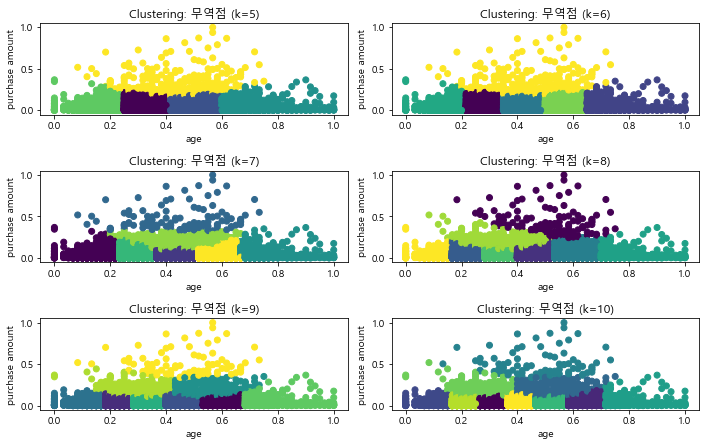

본점 (8682, 4)
  cluster age                   본점                          
          min max count mean   min        max count     mean
0       0  20  33  2057   29  1400   37424834  2057  2149931
1       1  50  59  1934   54  5750  101016512  1934  3757037
2       2  32  40  1873   36  2700   83079039  1873  3423329
3       3  59  80   769   64  4100  196699497   769  4931544
4       4  41  49  2049   45  6800  107166700  2049  3913496
  cluster age                   본점                          
          min max count mean   min        max count     mean
0       0  39  46  1556   41  8000  107166700  1556  4135764
1       1  54  62  1366   57  4650  196699497  1366  4119491
2       2  20  32  1667   29  1400   37424834  1667  2003340
3       3  46  53  1837   49  5750   73473908  1837  3591203
4       4  32  38  1807   35  2700   83079039  1807  3229822
5       5  63  80   449   67  4100  146465766   449  4623955
  cluster age                   본점                          
          m

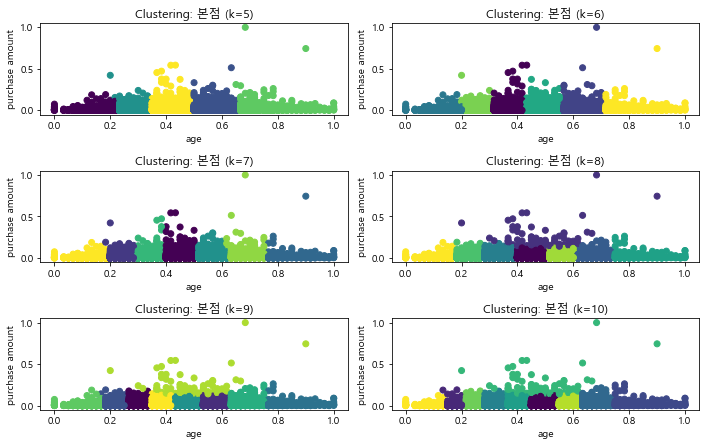

신촌점 (7018, 4)
  cluster age                   신촌점                          
          min max count mean    min        max count     mean
0       0  42  50  1651   46   4000   63195805  1651  3354153
1       1  20  33  1867   29   5000   27001800  1867  2054357
2       2  58  80   509   64  13000  114572352   509  4560675
3       3  33  41  1850   37   1500   37205287  1850  3395583
4       4  51  59  1141   54   6720   54899409  1141  3452319
  cluster age                   신촌점                          
          min max count mean    min        max count     mean
0       0  38  45  1238   41   4000   63195805  1238  3597622
1       1  53  62   925   57   6720   80021797   925  3929179
2       2  31  38  1918   34   1500   37205287  1918  3055875
3       3  46  53  1377   49   4300   54899409  1377  3165820
4       4  20  31  1258   28   5000   21227167  1258  1860881
5       5  62  80   302   67  13000  114572352   302  4190933
  cluster age                      신촌점                  

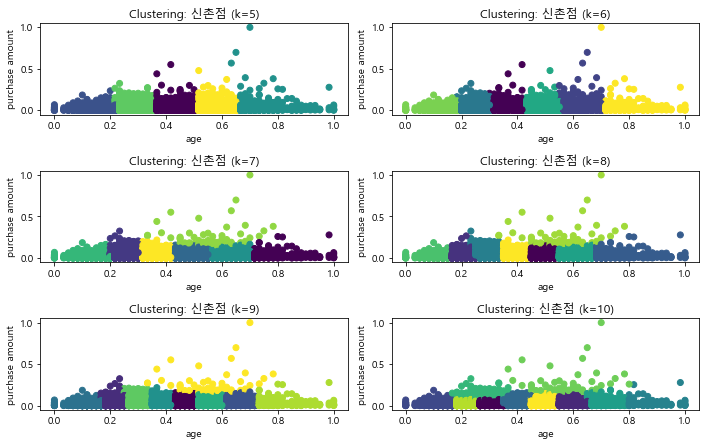

천호점 (5610, 4)
  cluster age                      천호점                          
          min max count mean       min       max count      mean
0       0  45  54  1548   48     14800  13106294  1548   3159130
1       1  20  35  1634   30      5000  20981000  1634   2212329
2       2  55  80   653   60     10000  24305177   653   3355796
3       3  35  44  1557   39      6072  16334420  1557   3153521
4       4  31  67   218   45  11596444  82413014   218  21312599
  cluster age                      천호점                          
          min max count mean       min       max count      mean
0       0  43  50  1461   46     14800  12455719  1461   3226749
1       1  20  33  1224   29      5820  20981000  1224   2130156
2       2  61  80   240   66     14036  24305177   240   3471045
3       3  51  60   858   54     10000  18505422   858   3341738
4       4  31  67   206   45  12422900  82413014   206  21837301
5       5  34  42  1621   37      5000  16334420  1621   2919467
  cluster a

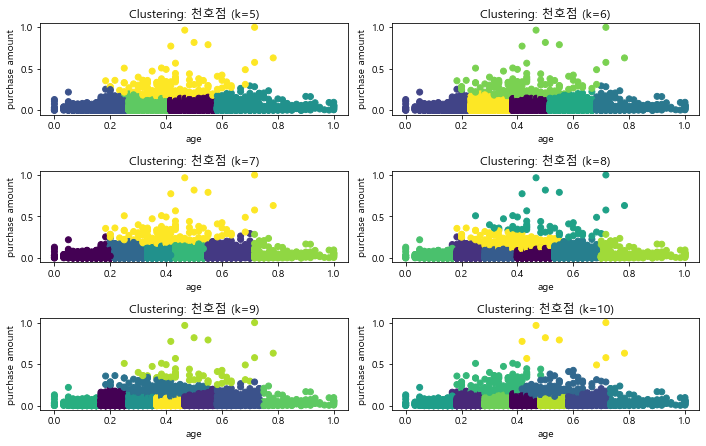

In [ ]:

cluster_df = data[['custid','age']]

for store in ['무역점','본점','신촌점','천호점'] :
  df_store = data[['custid','age',store]]
  df_store = df_store[df_store[store]>0].reset_index()
  print(store, df_store.shape)

  processed_data0 = df_store.copy()
  scaler = preprocessing.MinMaxScaler()
  processed_data0[['age', store]] = scaler.fit_transform(processed_data0[['age', store]])
  
  #클러스터 갯수 5개부터 10개까지
  plt.figure(figsize = (10, 10))
  for i in range(5,11):
    estimator = KMeans(n_clusters = i, random_state=0)
    ids = estimator.fit_predict(processed_data0[['age', store]])
    check = pd.concat([df_store, pd.DataFrame({'cluster' : ids})], axis=1)
    cluster_df = cluster_df.merge(check, on='custid')
    check = check.groupby('cluster')['age',store].agg(['min','max','count','mean']).reset_index().astype(int)
    print(check)
    plt.subplot(5, 2, i-4)
    plt.tight_layout()

    # 서브플롯의 라벨링
    plt.title("Clustering: {} (k={})".format(store,i))
    plt.xlabel('age')
    plt.ylabel('purchase amount')

    # 클러스터링 그리기
    plt.scatter(processed_data0['age'], processed_data0[store], c=ids)  
  plt.show()
  print('=====================================================================')

# k=10으로만 돌리기

무역점 (9666, 3)
  무역점 cluster age                      무역점                          
              min max count mean       min       max count      mean
0           0  36  41  1464   38      2720   6803759  1464   1550775
1           1  55  62  1025   57      7600  10657542  1025   1972419
2           2  20  29   982   26      8500  11337500   982   1568058
3           3  44  65   400   50   6315415  20884034   400  11018913
4           4  28  64    87   48  20306718  59353579    87  30048959
5           5  63  80   344   67      9000  21813340   344   2350977
6           6  48  54  1519   50      6000   6307068  1519   1634378
7           7  20  43   335   36   6250621  30776930   335  11151231
8           8  30  35  2034   32      3800   7641017  2034   1415551
9           9  42  47  1476   44      2500   8735436  1476   1905555


<Figure size 432x288 with 0 Axes>

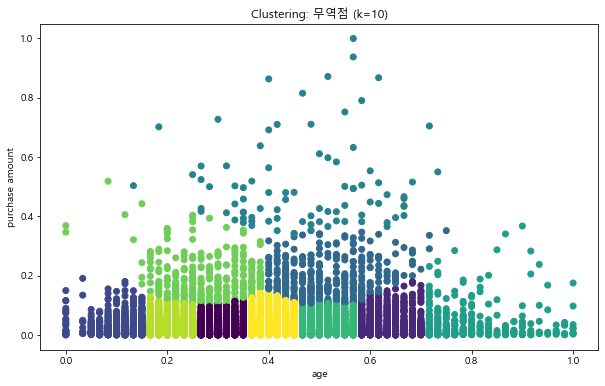

본점 (8682, 3)
  본점 cluster age                       본점                           
             min max count mean       min        max count      mean
0          0  47  52  1348   49      5750   24993602  1348   2893990
1          1  28  32  1118   30      1400   37424834  1118   2418780
2          2  65  80   319   69      6000   51750868   319   4314927
3          3  58  64   726   60      4100   42344278   726   4193686
4          4  37  41  1152   38      4500   34462436  1152   3439171
5          5  42  46  1116   43      8540   29883166  1116   3132909
6          6  32  74    81   49  25629279  196699497    81  47480648
7          7  33  36  1290   34      2700   34828330  1290   3051752
8          8  53  57   977   54      6700   27113990   977   2962937
9          9  20  28   555   26      4900   23975193   555   1350304


<Figure size 432x288 with 0 Axes>

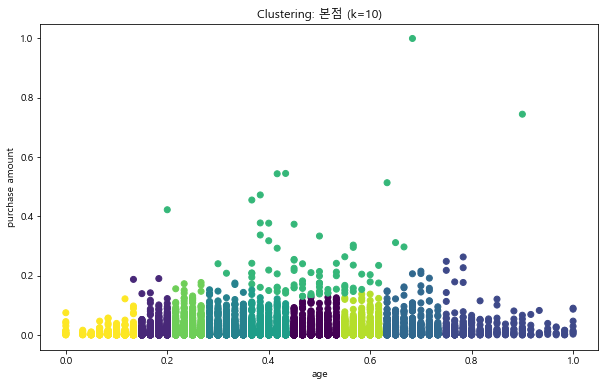

신촌점 (7018, 3)
  신촌점 cluster age                      신촌점                           
              min max count mean       min        max count      mean
0           0  36  41  1058   38      1500    9018352  1058   2266521
1           1  53  59   846   55      6720   16446228   846   2854958
2           2  20  30   985   27      5000   21227167   985   1788364
3           3  41  47   980   43      4000   17907524   980   3587066
4           4  68  80   102   72     13000   31883732   102   3517115
5           5  59  67   397   62     13000   21354677   397   3605633
6           6  30  42   186   36   7622679   37205287   186  13955180
7           7  42  68    58   54  16508848  114572352    58  30150986
8           8  31  35  1400   32      6000   10358829  1400   2126932
9           9  47  52  1006   49      5490   18351381  1006   2696874


<Figure size 432x288 with 0 Axes>

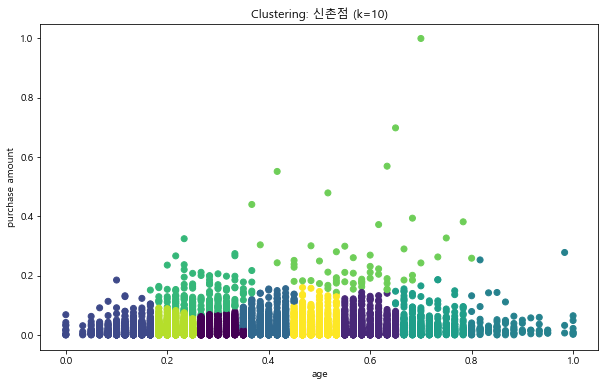

천호점 (5610, 3)
  천호점 cluster age                      천호점                          
              min max count mean       min       max count      mean
0           0  43  48  1096   45     14800  11829191  1096   3038828
1           1  30  36  1170   33      5000  14310035  1170   2420596
2           2  55  63   495   57     10000  16933946   495   2956841
3           3  44  63   198   50   8773253  35051036   198  14660681
4           4  64  80   142   69     14036  19486533   142   3363352
5           5  20  30   633   27      5820  18119272   633   1849125
6           6  31  49   122   40  11946839  42080293   122  20814686
7           7  37  42  1024   39     12000  11854435  1024   3002160
8           8  49  54   721   51     17060   8872940   721   2658268
9           9  45  67     9   55  40401160  82413014     9  60598062


<Figure size 432x288 with 0 Axes>

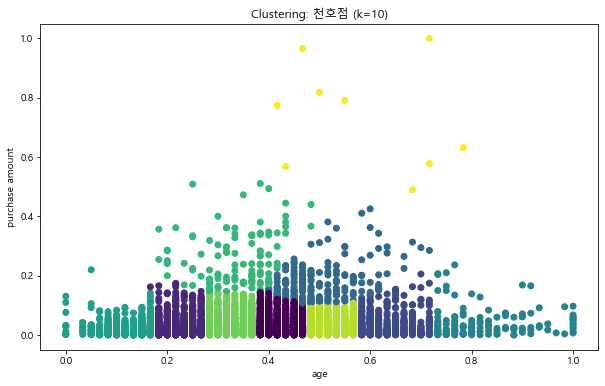

In [ ]:
cluster_df = data[['custid']]

for store in ['무역점','본점','신촌점','천호점'] :
  df_store = data[['custid','age',store]]
  df_store = df_store[df_store[store]>0].reset_index(drop=True)
  print(store, df_store.shape)


  # 클러스터링 전, 나이/구매금액 0~1단위로 스케일링
  processed_data0 = df_store.copy()
  scaler = preprocessing.MinMaxScaler()
  processed_data0[['age', store]] = scaler.fit_transform(processed_data0[['age', store]])
  
  #클러스터 갯수 10으로 고정
  i=10 
  estimator = KMeans(n_clusters = i, random_state=0)
  ids = estimator.fit_predict(processed_data0[['age', store]])
  check = pd.concat([df_store, pd.DataFrame({'cluster' : ids})], axis=1)
  check.columns = ['custid','age',store, str(store+' cluster') ]

  # 각 점포별 id의 클러스터 결과 DF로 합쳐서 저장
  cluster_df = cluster_df.merge(check[['custid',store,str(store+' cluster')]], on='custid', how='left')

  # 연령/금액 분할기준확인
  check = check.groupby(str(store+' cluster'))['age',store].agg(['min','max','count','mean']).reset_index().astype(int)
  print(check)

  # 클러스터링 그리기
  plt.tight_layout()
  plt.figure(figsize = (10, 6))
  plt.title("Clustering: {} (k={})".format(store,i))
  plt.xlabel('age')
  plt.ylabel('purchase amount')
  plt.scatter(processed_data0['age'], processed_data0[store], c=ids)  
  plt.show()

  print('=======================================================================================')

In [ ]:
cluster_df.head()

,custid,무역점,무역점 cluster,본점,본점 cluster,신촌점,신촌점 cluster,천호점,천호점 cluster
0,16,NaN,NaN,NaN,NaN,404034.0,2.0,3499100.0,5.0
1,29,NaN,NaN,NaN,NaN,NaN,NaN,1183830.0,5.0
2,33,2671322.0,2.0,317800.0,9.0,NaN,NaN,2090447.0,5.0
3,34,672150.0,2.0,1225800.0,9.0,NaN,NaN,149000.0,5.0
4,50,NaN,NaN,NaN,NaN,3580200.0,2.0,NaN,NaN


In [ ]:
cluster_df.to_csv('id_cluster.csv', index=False)

NameError: name 'cluster_df' is not defined

# VIP별로 DataFrame 각각 만들기 


In [ ]:
cluster_dic = {'store':['천호점','천호점','천호점','무역점','무역점','무역점', '본점','신촌점','신촌점'],
              'level' : ['youngVIP','oldVIP','VVIP', 'youngVIP','oldVIP','VVIP','VVIP','youngVIP','oldVIP'],
              'cluster' : [6,3,9,7,3,4,6,6,7]}

viplist_name = ['무역점_youngVIP', '무역점_oldVIP', '무역점VVIP','천호점_youngVIP', '천호점_oldVIP', '천호점VVIP','본점_VVIP','신촌점_youngVIP', '신촌점_oldVIP']

cluster_result = pd.DataFrame(data=cluster_dic)
cluster_result

,store,level,cluster
0,천호점,youngVIP,6
1,천호점,oldVIP,3
2,천호점,VVIP,9
3,무역점,youngVIP,7
4,무역점,oldVIP,3
5,무역점,VVIP,4
6,본점,VVIP,6
7,신촌점,youngVIP,6
8,신촌점,oldVIP,7


In [ ]:
무역점_youngVIP = cluster_df[cluster_df['무역점 cluster'] == 7]['custid'].tolist()
무역점_oldVIP = cluster_df[cluster_df['무역점 cluster'] == 3]['custid'].tolist()
무역점VVIP = cluster_df[cluster_df['무역점 cluster'] == 4]['custid'].tolist()

천호점_youngVIP = cluster_df[cluster_df['천호점 cluster'] == 6]['custid'].tolist()
천호점_oldVIP = cluster_df[cluster_df['천호점 cluster'] == 3]['custid'].tolist()
천호점VVIP = cluster_df[cluster_df['천호점 cluster'] == 9]['custid'].tolist()

본점_VVIP = cluster_df[cluster_df['본점 cluster'] == 6]['custid'].tolist()

신촌점_youngVIP = cluster_df[cluster_df['신촌점 cluster'] == 6]['custid'].tolist()
신촌점_oldVIP = cluster_df[cluster_df['신촌점 cluster'] == 7]['custid'].tolist()

### 각 지점 VIP 데이터 판다스 변환

In [ ]:
#무역점_youngVIP
M_youngVIP = pd.DataFrame(무역점_youngVIP)
M_youngVIP=M_youngVIP.rename(columns={M_youngVIP.columns[0]:'custid'})
M_youngVIP

,custid
0,1392
1,7067
2,9823
3,10047
4,11017
...,...
330,32345
331,32372
332,32719
333,32779


In [ ]:
#무역점_oldVIP
M_oldVIP = pd.DataFrame(무역점_oldVIP)
M_oldVIP=M_oldVIP.rename(columns={M_oldVIP.columns[0]:'custid'})
M_oldVIP

,custid
0,33210
1,33365
2,33392
3,33395
4,33403
...,...
395,46026
396,46467
397,46481
398,46487


In [ ]:
#무역점_VVIP
M_VVIP = pd.DataFrame(무역점VVIP)
M_VVIP=M_VVIP.rename(columns={M_VVIP.columns[0]:'custid'})
M_VVIP

,custid
0,7864
1,24599
2,24859
3,25138
4,26508
...,...
82,45078
83,45249
84,45883
85,46915


In [ ]:
#천호점_youngVIP
C_youngVIP = pd.DataFrame(천호점_youngVIP)
C_youngVIP=C_youngVIP.rename(columns={C_youngVIP.columns[0]:'custid'})
C_youngVIP

,custid
0,15649
1,16211
2,17495
3,17593
4,17609
...,...
117,33263
118,33798
119,33848
120,34090


In [ ]:
#천호점_oldVIP
C_oldVIP = pd.DataFrame(천호점_oldVIP)
C_oldVIP=C_oldVIP.rename(columns={C_oldVIP.columns[0]:'custid'})
C_oldVIP

,custid
0,33270
1,33346
2,33388
3,33791
4,33809
...,...
193,45367
194,45593
195,46716
196,47420


In [ ]:
#천호점_VVIP
C_VVIP = pd.DataFrame(천호점VVIP)
C_VVIP=C_VVIP.rename(columns={C_VVIP.columns[0]:'custid'})
C_VVIP

,custid
0,33002
1,35996
2,39870
3,47343
4,47958
5,48108
6,49057
7,37624
8,41934


In [ ]:
#본점_VVIP
B_VVIP = pd.DataFrame(본점_VVIP)
B_VVIP=B_VVIP.rename(columns={B_VVIP.columns[0]:'custid'})
B_VVIP

,custid
0,17073
1,30065
2,31665
3,31800
4,32532
...,...
76,43235
77,43493
78,45015
79,45467


In [ ]:
#신촌점_youngVIP
S_youngVIP = pd.DataFrame(신촌점_youngVIP)
S_youngVIP=S_youngVIP.rename(columns={S_youngVIP.columns[0]:'custid'})
S_youngVIP

,custid
0,14603
1,14864
2,15074
3,15118
4,15811
...,...
181,30314
182,30392
183,30852
184,31099


In [ ]:
#신촌점_oldVIP
S_oldVIP = pd.DataFrame(신촌점_oldVIP)
S_oldVIP=S_oldVIP.rename(columns={S_oldVIP.columns[0]:'custid'})
S_oldVIP

,custid
0,31485
1,34485
2,34717
3,36437
4,37078
5,37216
6,40036
7,40043
8,40328
9,40707


# Association rules

## 1. 무역점

In [ ]:
무역점 = tr[tr.store.isin(['무역점'])]
무역점

,datetime,custid,store,product,brand,corner,import,amount,installment
53,2001-03-04 10:30:00,33,무역점,2700000000000,식품,일반식품,0,66562,1
54,2001-02-13 13:43:00,33,무역점,4405620026000,지오다노,유니캐주얼,0,59600,3
55,2001-02-13 15:03:00,33,무역점,2116052008000,크리니크,화장품,1,29000,1
56,2001-02-13 16:53:00,33,무역점,4135140006900,아가타,장신구,0,38000,1
57,2001-04-13 17:30:00,33,무역점,2700000000000,식품,일반식품,0,41860,1
...,...,...,...,...,...,...,...,...,...
261586,2000-09-17 14:23:00,49992,무역점,2116050008000,에스티로더,화장품,1,27000,1
261588,2001-03-28 11:43:00,49992,무역점,4109160008000,크리스챤디올화장품,화장품,1,44000,1
261589,2000-07-13 12:33:00,49992,무역점,4100830008000,라프레리,화장품,1,112000,1
261591,2000-07-19 13:50:00,49992,무역점,4226950010053,김영주,디자이너부띠끄,0,564000,1


In [ ]:
#무역점 고객별 코너구매건수
basket1= (무역점.groupby(['custid','corner'])['custid'].sum().unstack().reset_index().fillna(0).set_index('custid'))
basket1

corner,가구,가전,기타바이어,니트단품,도자기크리스탈,디자이너부띠끄,문화완구,섬유,수입명품,스포츠,...,침구수예,캐릭터캐주얼,타운모피,트래디셔널캐주얼,피혁A,피혁B,행사장(남성),행사장(아동스포츠),행사장(잡화),화장품
custid,,,,,,,,,,,,,,,,,,,,,
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,66.0,0.0,0.0,0.0,0.0,165.0
34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0
54,0.0,0.0,0.0,108.0,0.0,0.0,0.0,162.0,0.0,54.0,...,0.0,108.0,0.0,0.0,108.0,54.0,0.0,0.0,0.0,54.0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99962.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49985,0.0,0.0,0.0,49985.0,0.0,0.0,0.0,49985.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49992,0.0,0.0,0.0,0.0,0.0,99984.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,199968.0


In [ ]:
#구매여부로 변환
def encode(x) :
      if x <= 0 :
           return 0
      if x >= 1 :
           return 1
basket1_sets = basket1.applymap(encode)
basket1_sets

corner,가구,가전,기타바이어,니트단품,도자기크리스탈,디자이너부띠끄,문화완구,섬유,수입명품,스포츠,...,침구수예,캐릭터캐주얼,타운모피,트래디셔널캐주얼,피혁A,피혁B,행사장(남성),행사장(아동스포츠),행사장(잡화),화장품
custid,,,,,,,,,,,,,,,,,,,,,
33,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
34,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
54,0,0,0,1,0,0,0,1,0,1,...,0,1,0,0,1,1,0,0,0,1
58,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
68,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49981,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
49985,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
49992,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### 무역점_youngVIP ###

In [ ]:
#무역점_youngVIP 코너별 구매여부
tr_M1 = M_youngVIP.merge(basket1_sets, on = 'custid', how = 'left')
tr_M1

,custid,가구,가전,기타바이어,니트단품,도자기크리스탈,디자이너부띠끄,문화완구,섬유,수입명품,...,침구수예,캐릭터캐주얼,타운모피,트래디셔널캐주얼,피혁A,피혁B,행사장(남성),행사장(아동스포츠),행사장(잡화),화장품
0,1392,0,1,0,1,0,0,0,1,1,...,0,1,0,1,1,0,0,0,0,1
1,7067,0,1,0,1,0,0,1,1,1,...,1,1,0,0,0,1,0,0,0,1
2,9823,0,0,0,1,0,0,0,1,0,...,0,1,0,1,1,1,0,0,0,1
3,10047,0,0,0,1,0,0,0,1,1,...,0,1,0,1,1,1,0,0,0,1
4,11017,1,0,0,1,1,0,0,1,1,...,1,1,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,32345,0,0,0,1,0,0,0,1,1,...,1,1,0,1,1,1,0,0,0,1
331,32372,1,1,0,1,0,0,0,0,1,...,1,1,0,1,1,0,0,0,0,1
332,32719,1,0,0,1,1,1,0,0,0,...,0,0,0,1,1,1,0,0,0,1
333,32779,1,0,0,1,0,1,0,0,1,...,1,0,0,0,0,1,0,0,0,1


In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [ ]:
basket_m1 = apriori(tr_M1.drop(['custid'],axis=1), min_support=0.60, use_colnames=True)
basket_m1.sort_values('support',ascending = False)

,support,itemsets
13,0.967164,(화장품)
8,0.892537,(일반식품)
41,0.871642,"(화장품, 일반식품)"
4,0.850746,(스포츠)
31,0.823881,"(화장품, 스포츠)"
...,...,...
58,0.602985,"(화장품, 스포츠, 조리욕실)"
30,0.602985,"(캐릭터캐주얼, 스포츠)"
51,0.600000,"(스포츠, 섬유, 일반식품)"
42,0.600000,"(화장품, 장신구)"


In [ ]:
association_rules(basket_m1, metric = 'lift', min_threshold = 1.1).sort_values('confidence',ascending = False)

#무역점_youngVIP : 유아동복,화장품->문화완구

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,"(화장품, 문화완구)",(유아동복),0.662687,0.782090,0.620896,0.936937,1.197992,0.102615,3.455437
0,(문화완구),(유아동복),0.674627,0.782090,0.629851,0.933628,1.193761,0.102232,3.283184
4,(문화완구),"(화장품, 유아동복)",0.674627,0.761194,0.620896,0.920354,1.209092,0.107374,2.998342
3,"(화장품, 유아동복)",(문화완구),0.761194,0.674627,0.620896,0.815686,1.209092,0.107374,1.765322
1,(유아동복),(문화완구),0.782090,0.674627,0.629851,0.805344,1.193761,0.102232,1.671525
5,(유아동복),"(화장품, 문화완구)",0.782090,0.662687,0.620896,0.793893,1.197992,0.102615,1.636595


### 무역점_oldVIP

In [ ]:
tr_M2 = M_oldVIP.merge(basket1_sets, on = 'custid', how = 'left')
tr_M2

,custid,가구,가전,기타바이어,니트단품,도자기크리스탈,디자이너부띠끄,문화완구,섬유,수입명품,...,침구수예,캐릭터캐주얼,타운모피,트래디셔널캐주얼,피혁A,피혁B,행사장(남성),행사장(아동스포츠),행사장(잡화),화장품
0,33210,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,33365,1,1,0,1,1,0,1,1,1,...,0,1,0,1,1,0,0,0,0,1
2,33392,0,1,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,1
3,33395,0,0,0,0,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,1
4,33403,0,1,0,0,1,0,0,1,1,...,1,1,0,1,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,46026,0,1,0,1,1,1,0,0,1,...,1,0,0,0,1,0,0,0,0,1
396,46467,1,1,0,0,0,1,0,0,0,...,1,1,0,0,1,0,0,0,0,1
397,46481,1,0,0,1,0,1,1,1,1,...,0,1,0,1,1,0,0,0,0,1
398,46487,1,0,1,1,1,1,0,0,0,...,1,1,0,1,1,0,0,0,0,1


In [ ]:
basket_m2 = apriori(tr_M2.drop(['custid'],axis=1), min_support=0.70, use_colnames=True)
basket_m2.sort_values('support',ascending = False)

,support,itemsets
6,0.9600,(화장품)
2,0.8750,(스포츠)
4,0.8750,(일반식품)
10,0.8500,"(화장품, 스포츠)"
12,0.8475,"(화장품, 일반식품)"
9,0.7825,"(스포츠, 일반식품)"
0,0.7800,(니트단품)
14,0.7625,"(화장품, 스포츠, 일반식품)"
8,0.7575,"(화장품, 니트단품)"
5,0.7550,(피혁A)


In [ ]:
association_rules(basket_m2, metric = 'lift', min_threshold = 1.02).sort_values('confidence',ascending = False)

#무역점_oldVIP : 스포츠 -> 화장품, 일반식품

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,"(화장품, 일반식품)",(스포츠),0.8475,0.8750,0.7625,0.899705,1.028234,0.020937,1.246324
1,(니트단품),(스포츠),0.7800,0.8750,0.7000,0.897436,1.025641,0.017500,1.218750
4,"(화장품, 스포츠)",(일반식품),0.8500,0.8750,0.7625,0.897059,1.025210,0.018750,1.214286
2,(스포츠),(일반식품),0.8750,0.8750,0.7825,0.894286,1.022041,0.016875,1.182432
3,(일반식품),(스포츠),0.8750,0.8750,0.7825,0.894286,1.022041,0.016875,1.182432
6,(스포츠),"(화장품, 일반식품)",0.8750,0.8475,0.7625,0.871429,1.028234,0.020937,1.186111
7,(일반식품),"(화장품, 스포츠)",0.8750,0.8500,0.7625,0.871429,1.025210,0.018750,1.166667
0,(스포츠),(니트단품),0.8750,0.7800,0.7000,0.800000,1.025641,0.017500,1.100000


### 무역점 VVIP

In [ ]:
tr_M3 = M_VVIP.merge(basket1_sets, on = 'custid', how = 'left')
tr_M3

,custid,가구,가전,기타바이어,니트단품,도자기크리스탈,디자이너부띠끄,문화완구,섬유,수입명품,...,침구수예,캐릭터캐주얼,타운모피,트래디셔널캐주얼,피혁A,피혁B,행사장(남성),행사장(아동스포츠),행사장(잡화),화장품
0,7864,0,1,0,1,0,0,0,1,1,...,0,1,0,1,1,1,0,0,0,1
1,24599,1,1,0,1,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,1
2,24859,0,0,0,1,0,1,1,1,0,...,0,1,1,0,1,0,0,0,0,1
3,25138,0,1,0,1,0,1,1,1,1,...,0,1,0,1,1,1,0,0,0,1
4,26508,1,1,0,1,1,1,1,0,1,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,45078,0,1,0,1,1,0,0,1,1,...,1,1,0,1,1,0,0,0,0,1
83,45249,0,1,0,1,1,1,0,1,1,...,1,0,0,1,1,0,0,0,0,1
84,45883,0,0,0,1,1,0,1,1,1,...,1,1,0,1,1,1,0,0,0,1
85,46915,1,0,0,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
basket_m3 = apriori(tr_M3.drop(['custid'],axis=1), min_support=0.70, use_colnames=True)
basket_m3.sort_values('support',ascending = False)

,support,itemsets
11,0.965517,(화장품)
5,0.919540,(일반식품)
40,0.885057,"(화장품, 일반식품)"
1,0.850575,(섬유)
3,0.839080,(스포츠)
...,...,...
67,0.701149,"(유니캐주얼, 피혁A, 일반식품)"
66,0.701149,"(화장품, 스포츠, 피혁A)"
29,0.701149,"(스포츠, 피혁A)"
36,0.701149,"(일반식품, 조리욕실)"


In [ ]:
association_rules(basket_m3, metric = 'lift', min_threshold = 1.1).sort_values('confidence',ascending = False)

#무역점 VVIP : 트래디셔널캐쥬얼->화장품, 섬유, 일반식품

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
71,"(트래디셔널캐주얼, 섬유)","(화장품, 일반식품)",0.724138,0.885057,0.712644,0.984127,1.111936,0.071740,7.241379
68,"(트래디셔널캐주얼, 화장품, 일반식품)",(섬유),0.735632,0.850575,0.712644,0.968750,1.138936,0.086934,4.781609
22,"(트래디셔널캐주얼, 일반식품)",(섬유),0.735632,0.850575,0.712644,0.968750,1.138936,0.086934,4.781609
72,"(트래디셔널캐주얼, 일반식품)","(화장품, 섬유)",0.735632,0.827586,0.712644,0.968750,1.170573,0.103845,5.517241
0,(트래디셔널캐주얼),(섬유),0.758621,0.850575,0.724138,0.954545,1.122236,0.078874,3.287356
...,...,...,...,...,...,...,...,...,...
14,(스포츠),"(유니캐주얼, 섬유)",0.839080,0.747126,0.701149,0.835616,1.118440,0.074250,1.538314
57,(스포츠),"(화장품, 섬유, 유니캐주얼)",0.839080,0.747126,0.701149,0.835616,1.118440,0.074250,1.538314
58,(섬유),"(화장품, 스포츠, 유니캐주얼)",0.850575,0.735632,0.701149,0.824324,1.120566,0.075439,1.504863
15,(섬유),"(유니캐주얼, 스포츠)",0.850575,0.735632,0.701149,0.824324,1.120566,0.075439,1.504863


## 2. 천호점

In [ ]:
천호점 = tr[tr.store.isin(['천호점'])]
천호점

,datetime,custid,store,product,brand,corner,import,amount,installment
0,2000-10-17 18:33:00,16,천호점,4100110001100,비비안스타킹,섬유,0,25000,1
2,2001-01-08 18:50:00,16,천호점,4218410011030,예스비,영캐주얼,0,131000,6
3,2001-03-21 19:13:00,16,천호점,4209563011000,SJ,영캐주얼,0,330000,5
4,2001-04-10 12:00:00,16,천호점,4242470011010,올리브,영캐주얼,0,214200,3
5,2000-11-15 14:53:00,16,천호점,4104840008000,샤넬,화장품,1,29000,1
...,...,...,...,...,...,...,...,...,...
261671,2000-07-14 19:20:00,49998,천호점,2700000000000,식품,일반식품,0,11568,1
261672,2000-06-28 17:10:00,49998,천호점,4409230020400,팅클,유아동복,0,29000,1
261673,2000-11-26 19:10:00,49998,천호점,2700000000000,식품,일반식품,0,4550,1
261674,2000-11-10 17:14:00,49998,천호점,6133910008000,더바디,화장품,0,91000,1


In [ ]:
#천호점 고객별 코너구매건수
basket2= (천호점.groupby(['custid','corner'])['custid'].sum().unstack().reset_index().fillna(0).set_index('custid'))
basket2

corner,가구,가전,기타바이어,니트단품,도자기크리스탈,디자이너부띠끄,문화완구,생활용품,섬유,수입명품,...,청과곡물,침구수예,캐릭터캐주얼,타운모피,트래디셔널캐주얼,피혁A,피혁B,행사장(아동스포츠),행사장(여성캐주얼),화장품
custid,,,,,,,,,,,,,,,,,,,,,
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,32.0,...,0.0,0.0,32.0,0.0,0.0,0.0,64.0,0.0,0.0,80.0
29,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,58.0
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,0.0,...,0.0,0.0,0.0,0.0,33.0,33.0,0.0,0.0,0.0,165.0
34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0
54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49965,49965.0,49965.0,0.0,199860.0,49965.0,0.0,99930.0,0.0,49965.0,0.0,...,0.0,0.0,99930.0,0.0,849405.0,99930.0,49965.0,0.0,0.0,399720.0
49976,0.0,0.0,49976.0,149928.0,49976.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,49976.0,49976.0,0.0,0.0,149928.0
49979,0.0,149937.0,49979.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,49979.0,0.0,49979.0,0.0,0.0,0.0,299874.0


In [ ]:
#구매여부로 변환
def encode(x) :
      if x <= 0 :
           return 0
      if x >= 1 :
           return 1
basket2_sets = basket2.applymap(encode)
basket2_sets

corner,가구,가전,기타바이어,니트단품,도자기크리스탈,디자이너부띠끄,문화완구,생활용품,섬유,수입명품,...,청과곡물,침구수예,캐릭터캐주얼,타운모피,트래디셔널캐주얼,피혁A,피혁B,행사장(아동스포츠),행사장(여성캐주얼),화장품
custid,,,,,,,,,,,,,,,,,,,,,
16,0,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,0,1
29,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
33,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
34,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
54,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49965,1,1,0,1,1,0,1,0,1,0,...,0,0,1,0,1,1,1,0,0,1
49976,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
49979,0,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1


### 천호점_youngVIP 

In [ ]:
#천호점_youngVIP 코너별 구매여부
tr_C1 = C_youngVIP.merge(basket2_sets, on = 'custid', how = 'left')
tr_C1

,custid,가구,가전,기타바이어,니트단품,도자기크리스탈,디자이너부띠끄,문화완구,생활용품,섬유,...,청과곡물,침구수예,캐릭터캐주얼,타운모피,트래디셔널캐주얼,피혁A,피혁B,행사장(아동스포츠),행사장(여성캐주얼),화장품
0,15649,1,1,1,1,0,1,1,0,1,...,0,0,1,0,1,1,0,0,0,1
1,16211,0,0,0,1,0,0,0,0,0,...,0,0,1,1,1,1,1,0,0,1
2,17495,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,1,0,0,1
3,17593,1,1,1,1,1,0,0,0,1,...,0,1,1,0,1,1,1,0,0,1
4,17609,0,1,1,1,0,0,1,0,1,...,0,0,1,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,33263,0,0,1,1,0,1,0,0,1,...,0,1,1,0,1,1,0,0,0,1
118,33798,0,1,1,1,1,0,1,1,1,...,0,1,1,1,1,1,1,0,0,1
119,33848,1,1,1,1,0,1,0,0,1,...,0,1,1,1,1,1,1,0,0,1
120,34090,0,1,1,1,1,0,1,0,1,...,0,1,1,0,1,1,0,0,0,1


In [ ]:
basket_c1 = apriori(tr_C1.drop(['custid'],axis=1), min_support=0.80, use_colnames=True)
basket_c1.sort_values('support',ascending = False)

,support,itemsets
10,1.000000,(화장품)
6,0.926230,(일반식품)
30,0.926230,"(화장품, 일반식품)"
3,0.918033,(스포츠)
24,0.918033,"(화장품, 스포츠)"
33,0.909836,"(화장품, 피혁A)"
9,0.909836,(피혁A)
28,0.885246,"(화장품, 유니캐주얼)"
2,0.885246,(섬유)
5,0.885246,(유니캐주얼)


In [ ]:
association_rules(basket_c1, metric = 'lift', min_threshold = 1.04).sort_values('confidence',ascending = False)

#천호점_youngVIP : 니트단품->스포츠

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
9,(니트단품),"(화장품, 스포츠)",0.868852,0.918033,0.836066,0.962264,1.048181,0.038431,2.172131
7,"(화장품, 니트단품)",(스포츠),0.868852,0.918033,0.836066,0.962264,1.048181,0.038431,2.172131
1,(니트단품),(스포츠),0.868852,0.918033,0.836066,0.962264,1.048181,0.038431,2.172131
16,(섬유),"(화장품, 유니캐주얼)",0.885246,0.885246,0.819672,0.925926,1.045953,0.036012,1.549180
15,"(화장품, 유니캐주얼)",(섬유),0.885246,0.885246,0.819672,0.925926,1.045953,0.036012,1.549180
14,"(화장품, 섬유)",(유니캐주얼),0.885246,0.885246,0.819672,0.925926,1.045953,0.036012,1.549180
17,(유니캐주얼),"(화장품, 섬유)",0.885246,0.885246,0.819672,0.925926,1.045953,0.036012,1.549180
5,(섬유),(유니캐주얼),0.885246,0.885246,0.819672,0.925926,1.045953,0.036012,1.549180
4,(유니캐주얼),(섬유),0.885246,0.885246,0.819672,0.925926,1.045953,0.036012,1.549180
10,"(화장품, 니트단품)",(유니캐주얼),0.868852,0.885246,0.803279,0.924528,1.044375,0.034131,1.520492


### 천호점_oldVIP 

In [ ]:
#천호점_oldVIP 코너별 구매여부
tr_C2 = C_oldVIP.merge(basket2_sets, on = 'custid', how = 'left')
tr_C2

,custid,가구,가전,기타바이어,니트단품,도자기크리스탈,디자이너부띠끄,문화완구,생활용품,섬유,...,청과곡물,침구수예,캐릭터캐주얼,타운모피,트래디셔널캐주얼,피혁A,피혁B,행사장(아동스포츠),행사장(여성캐주얼),화장품
0,33270,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
1,33346,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,33388,1,1,0,1,0,1,0,0,1,...,0,1,0,1,0,0,1,0,0,1
3,33791,0,0,1,0,0,1,0,0,1,...,0,0,1,1,0,1,1,0,0,1
4,33809,0,0,0,1,0,1,0,0,1,...,0,0,0,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,45367,0,1,1,1,0,1,0,0,1,...,0,0,1,1,1,1,0,0,0,1
194,45593,0,1,1,1,0,1,0,0,1,...,0,1,1,1,1,1,1,0,0,1
195,46716,1,1,1,1,1,1,0,0,0,...,0,1,1,0,1,0,1,0,0,1
196,47420,0,1,1,1,0,0,1,0,1,...,0,0,1,1,1,1,1,0,0,1


In [ ]:
basket_c2 = apriori(tr_C2.drop(['custid'],axis=1), min_support=0.60, use_colnames=True)
basket_c2.sort_values('support',ascending = False)

,support,itemsets
13,0.979798,(화장품)
3,0.949495,(스포츠)
43,0.934343,"(화장품, 스포츠)"
1,0.888889,(니트단품)
26,0.878788,"(화장품, 니트단품)"
...,...,...
35,0.601010,"(스포츠, 엘레강스캐주얼)"
179,0.601010,"(화장품, 영캐주얼, 스포츠, 피혁A)"
159,0.601010,"(화장품, 영캐주얼, 니트단품, 유니캐주얼)"
160,0.601010,"(화장품, 영캐주얼, 니트단품, 일반식품)"


In [ ]:
association_rules(basket_c2, metric = 'lift', min_threshold = 1.1).sort_values('confidence',ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7,"(니트단품, 스포츠, 영캐주얼)",(유니캐주얼),0.646465,0.843434,0.601010,0.929687,1.102264,0.055760,2.226712
3,"(스포츠, 영캐주얼)",(유니캐주얼),0.702020,0.843434,0.651515,0.928058,1.100332,0.059407,2.176263
21,"(스포츠, 영캐주얼)","(화장품, 유니캐주얼)",0.702020,0.833333,0.646465,0.920863,1.105036,0.061448,2.106061
5,(영캐주얼),"(유니캐주얼, 스포츠)",0.717172,0.823232,0.651515,0.908451,1.103517,0.061116,1.930847
11,"(니트단품, 영캐주얼)","(유니캐주얼, 스포츠)",0.661616,0.823232,0.601010,0.908397,1.103452,0.056346,1.929714
19,"(화장품, 영캐주얼)","(유니캐주얼, 스포츠)",0.712121,0.823232,0.646465,0.907801,1.102728,0.060223,1.917249
23,(영캐주얼),"(화장품, 스포츠, 유니캐주얼)",0.717172,0.813131,0.646465,0.901408,1.108564,0.063310,1.895382
10,"(스포츠, 영캐주얼)","(유니캐주얼, 니트단품)",0.702020,0.752525,0.601010,0.856115,1.137656,0.072722,1.719949
1,(영캐주얼),"(유니캐주얼, 니트단품)",0.717172,0.752525,0.606061,0.845070,1.122979,0.066371,1.597337
15,"(화장품, 영캐주얼)","(유니캐주얼, 니트단품)",0.712121,0.752525,0.601010,0.843972,1.121519,0.065121,1.586088


### 천호점VVIP

In [ ]:
#천호점VVIP 코너별 구매여부
tr_C3 = C_VVIP.merge(basket2_sets, on = 'custid', how = 'left')
tr_C3

,custid,가구,가전,기타바이어,니트단품,도자기크리스탈,디자이너부띠끄,문화완구,생활용품,섬유,...,청과곡물,침구수예,캐릭터캐주얼,타운모피,트래디셔널캐주얼,피혁A,피혁B,행사장(아동스포츠),행사장(여성캐주얼),화장품
0,33002,0,1,1,1,0,0,0,0,0,...,0,0,1,1,1,1,1,0,0,1
1,35996,1,1,1,1,0,1,1,0,1,...,0,1,1,0,1,1,1,0,0,1
2,39870,0,0,1,0,0,1,0,0,0,...,0,0,1,0,1,1,0,0,0,1
3,47343,1,1,1,1,0,1,0,0,0,...,0,1,0,0,1,1,0,0,0,1
4,47958,1,0,1,1,1,1,0,0,1,...,0,1,1,1,1,1,1,0,0,1
5,48108,1,1,1,1,1,1,1,0,1,...,0,1,0,0,1,1,1,0,0,1
6,49057,0,0,1,1,0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,1
7,37624,1,1,0,1,1,1,1,0,1,...,0,0,1,1,1,1,1,0,0,1
8,41934,0,1,1,1,0,1,0,0,1,...,0,0,1,0,1,1,1,0,0,1


In [ ]:
basket_c3 = apriori(tr_C3.drop(['custid'],axis=1), min_support=0.70, use_colnames=True)
basket_c3.sort_values('support',ascending = False)

,support,itemsets
166,1.000000,"(화장품, 스포츠, 피혁A)"
8,1.000000,(피혁A)
48,1.000000,"(화장품, 스포츠)"
60,1.000000,"(화장품, 피혁A)"
46,1.000000,"(스포츠, 피혁A)"
...,...,...
206,0.777778,"(트래디셔널캐주얼, 기타바이어, 피혁A, 스포츠)"
205,0.777778,"(화장품, 기타바이어, 일반식품, 스포츠)"
204,0.777778,"(기타바이어, 피혁A, 일반식품, 스포츠)"
203,0.777778,"(화장품, 기타바이어, 스포츠, 엘레강스캐주얼)"


In [ ]:
association_rules(basket_c3, metric = 'lift', min_threshold = 1.1).sort_values('confidence',ascending = False)

#천호점VVIP : 니트단품,일반식품 -> 수입명품, 디자이너부띠끄

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(수입명품),(니트단품),0.888889,0.888889,0.888889,1.000,1.125000,0.098765,inf
3344,"(수입명품, 일반식품)","(니트단품, 화장품, 스포츠, 디자이너부띠끄)",0.777778,0.777778,0.777778,1.000,1.285714,0.172840,inf
3656,"(화장품, 스포츠, 니트단품, 일반식품)","(디자이너부띠끄, 엘레강스캐주얼)",0.777778,0.777778,0.777778,1.000,1.285714,0.172840,inf
3655,"(스포츠, 니트단품, 일반식품, 엘레강스캐주얼)","(화장품, 디자이너부띠끄)",0.777778,0.888889,0.777778,1.000,1.125000,0.086420,inf
3654,"(화장품, 스포츠, 일반식품, 엘레강스캐주얼)","(니트단품, 디자이너부띠끄)",0.777778,0.777778,0.777778,1.000,1.285714,0.172840,inf
...,...,...,...,...,...,...,...,...,...
3907,"(엘레강스캐주얼, 수입명품, 피혁A, 스포츠)","(트래디셔널캐주얼, 니트단품)",0.888889,0.777778,0.777778,0.875,1.125000,0.086420,1.777778
1394,"(니트단품, 피혁A)","(수입명품, 디자이너부띠끄, 엘레강스캐주얼)",0.888889,0.777778,0.777778,0.875,1.125000,0.086420,1.777778
3909,"(니트단품, 수입명품, 피혁A, 스포츠)","(트래디셔널캐주얼, 엘레강스캐주얼)",0.888889,0.777778,0.777778,0.875,1.125000,0.086420,1.777778
1393,"(피혁A, 엘레강스캐주얼)","(니트단품, 수입명품, 디자이너부띠끄)",0.888889,0.777778,0.777778,0.875,1.125000,0.086420,1.777778


## 3. 본점

In [ ]:
본점 = tr[tr.store.isin(['본점'])]
본점

,datetime,custid,store,product,brand,corner,import,amount,installment
70,2001-04-12 18:30:00,33,본점,6315970019900,폴로,트래디셔널캐주얼,0,180000,3
104,2001-04-12 19:00:00,33,본점,6300032017000,빈폴,트래디셔널캐주얼,0,98000,3
107,2001-04-12 18:40:00,33,본점,4405620026000,지오다노,유니캐주얼,0,39800,1
110,2001-01-14 16:10:00,34,본점,4125900006670,쟝폴클라리쎄,장신구,0,20000,1
111,2000-12-17 18:30:00,34,본점,4130490001900,현대우양산,섬유,0,20000,1
...,...,...,...,...,...,...,...,...,...
261634,2000-07-09 14:50:00,49997,본점,4123560008000,클라란스,화장품,1,36000,1
261635,2000-08-05 14:00:00,49997,본점,4125440008000,시슬리,화장품,1,60000,1
261636,2001-01-05 18:50:00,49997,본점,4239550026000,CK,유니캐주얼,0,50000,1
261638,2001-01-05 18:30:00,49997,본점,4234190013100,바바라,니트단품,1,150000,1


In [ ]:
#본점 고객별 코너구매건수
basket3= (본점.groupby(['custid','corner'])['custid'].sum().unstack().reset_index().fillna(0).set_index('custid'))
basket3

corner,가구,가전,기타바이어,니트단품,도자기크리스탈,디자이너부띠끄,문화완구,생활용품,섬유,수입명품,...,조리욕실,침구수예,캐릭터캐주얼,타운모피,트래디셔널캐주얼,피혁A,피혁B,행사장(여성정장),행사장(여성캐주얼),화장품
custid,,,,,,,,,,,,,,,,,,,,,
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,66.0,0.0,0.0,0.0,0.0,0.0
34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0
58,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,116.0,116.0,...,0.0,0.0,0.0,0.0,116.0,58.0,116.0,0.0,0.0,232.0
68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49985,0.0,49985.0,0.0,149955.0,49985.0,49985.0,0.0,0.0,49985.0,0.0,...,99970.0,0.0,0.0,0.0,0.0,0.0,49985.0,0.0,0.0,99970.0
49992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49992.0,49992.0,...,49992.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,199968.0
49994,0.0,0.0,49994.0,0.0,0.0,99988.0,0.0,0.0,349958.0,399952.0,...,0.0,0.0,749910.0,0.0,49994.0,249970.0,549934.0,0.0,0.0,399952.0


In [ ]:
#구매여부로 변환
def encode(x) :
      if x <= 0 :
           return 0
      if x >= 1 :
           return 1
basket3_sets = basket3.applymap(encode)
basket3_sets

corner,가구,가전,기타바이어,니트단품,도자기크리스탈,디자이너부띠끄,문화완구,생활용품,섬유,수입명품,...,조리욕실,침구수예,캐릭터캐주얼,타운모피,트래디셔널캐주얼,피혁A,피혁B,행사장(여성정장),행사장(여성캐주얼),화장품
custid,,,,,,,,,,,,,,,,,,,,,
33,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
34,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
58,0,0,1,0,0,0,0,0,1,1,...,0,0,0,0,1,1,1,0,0,1
68,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
84,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49985,0,1,0,1,1,1,0,0,1,0,...,1,0,0,0,0,0,1,0,0,1
49992,0,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,1
49994,0,0,1,0,0,1,0,0,1,1,...,0,0,1,0,1,1,1,0,0,1


### 본점 VVIP

In [ ]:
#본점_VVIP 코너별 구매여부
tr_B1 = B_VVIP.merge(basket3_sets, on = 'custid', how = 'left')
tr_B1

,custid,가구,가전,기타바이어,니트단품,도자기크리스탈,디자이너부띠끄,문화완구,생활용품,섬유,...,조리욕실,침구수예,캐릭터캐주얼,타운모피,트래디셔널캐주얼,피혁A,피혁B,행사장(여성정장),행사장(여성캐주얼),화장품
0,17073,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,1,0,0,1
1,30065,0,1,0,1,1,0,1,1,1,...,1,1,1,0,1,0,0,0,0,1
2,31665,0,1,0,1,1,0,1,1,1,...,1,0,1,0,1,1,1,0,0,1
3,31800,0,0,0,0,0,0,1,0,1,...,1,1,1,0,1,1,1,0,0,1
4,32532,0,1,0,0,0,0,1,0,1,...,1,0,1,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,43235,0,1,1,1,0,1,1,0,1,...,0,1,0,0,1,1,0,0,0,1
77,43493,0,0,0,1,0,1,0,0,1,...,0,0,1,0,1,1,1,0,0,1
78,45015,0,1,0,1,1,1,0,0,0,...,1,1,1,1,1,0,0,0,0,1
79,45467,0,1,1,1,0,1,0,0,1,...,0,0,1,0,1,1,1,0,0,1


In [ ]:
basket_b1 = apriori(tr_B1.drop(['custid'],axis=1), min_support=0.70, use_colnames=True)
basket_b1.sort_values('support',ascending = False)

,support,itemsets
7,0.987654,(화장품)
4,0.938272,(일반식품)
20,0.925926,"(화장품, 수입명품)"
2,0.925926,(수입명품)
24,0.925926,"(화장품, 일반식품)"
1,0.876543,(섬유)
16,0.864198,"(화장품, 섬유)"
18,0.864198,"(수입명품, 일반식품)"
43,0.864198,"(화장품, 수입명품, 일반식품)"
0,0.839506,(니트단품)


In [ ]:
association_rules(basket_b1, metric = 'lift', min_threshold = 1.04).sort_values('confidence',ascending = False)

#본점VVIP : 스포츠 -> 섬유, 일반식품

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
8,"(스포츠, 섬유)",(일반식품),0.728395,0.938272,0.716049,0.983051,1.047725,0.032617,3.641975
38,"(화장품, 스포츠, 섬유)",(일반식품),0.716049,0.938272,0.703704,0.982759,1.047414,0.031855,3.580247
59,"(수입명품, 장신구)","(화장품, 일반식품)",0.728395,0.925926,0.703704,0.966102,1.043390,0.029264,2.185185
54,"(수입명품, 스포츠)","(화장품, 일반식품)",0.728395,0.925926,0.703704,0.966102,1.043390,0.029264,2.185185
44,"(스포츠, 섬유)","(화장품, 일반식품)",0.728395,0.925926,0.703704,0.966102,1.043390,0.029264,2.185185
...,...,...,...,...,...,...,...,...,...
13,(일반식품),"(스포츠, 섬유)",0.938272,0.728395,0.716049,0.763158,1.047725,0.032617,1.146776
43,"(화장품, 일반식품)","(스포츠, 섬유)",0.925926,0.728395,0.703704,0.760000,1.043390,0.029264,1.131687
51,"(화장품, 일반식품)","(수입명품, 스포츠)",0.925926,0.728395,0.703704,0.760000,1.043390,0.029264,1.131687
58,"(화장품, 일반식품)","(수입명품, 장신구)",0.925926,0.728395,0.703704,0.760000,1.043390,0.029264,1.131687


## 4. 신촌점

In [ ]:
신촌점 = tr[tr.store.isin(['신촌점'])]
신촌점

,datetime,custid,store,product,brand,corner,import,amount,installment
1,2001-01-09 17:43:00,16,신촌점,2139143008000,비오뗌,화장품,0,30000,1
8,2001-02-11 15:23:00,16,신촌점,4109350003200,탠디,피혁A,0,138000,3
10,2001-03-13 14:13:00,16,신촌점,4132320008000,아베다,화장품,0,49000,1
12,2001-03-13 14:30:00,16,신촌점,2700000000000,식품,일반식품,0,21034,1
18,2001-01-09 18:03:00,16,신촌점,2139141008000,랑콤,화장품,0,152000,3
...,...,...,...,...,...,...,...,...,...
261479,2000-10-31 15:30:00,49975,신촌점,4135060003984,운스구르페,피혁A,0,89000,3
261548,2000-06-02 12:40:00,49981,신촌점,4207930013076,정호진,니트단품,0,30000,1
261551,2000-06-02 13:20:00,49981,신촌점,2700000000000,식품,일반식품,0,15607,1
261561,2000-05-20 11:53:00,49981,신촌점,4124180008000,시세이도,화장품,1,100000,3


In [ ]:
#신촌점 고객별 코너구매건수
basket4= (신촌점.groupby(['custid','corner'])['custid'].sum().unstack().reset_index().fillna(0).set_index('custid'))
basket4

corner,가구,가전,기타바이어,니트단품,도자기크리스탈,디자이너부띠끄,문화완구,섬유,수입명품,스포츠,...,조리욕실,침구수예,캐릭터캐주얼,타운모피,트래디셔널캐주얼,피혁A,피혁B,행사장(남성),행사장(여성캐쥬),화장품
custid,,,,,,,,,,,,,,,,,,,,,
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,48.0
50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,0.0,250.0,...,0.0,50.0,50.0,0.0,150.0,150.0,50.0,0.0,0.0,150.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,351.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,234.0,117.0,0.0,0.0,117.0
163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,652.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,99854.0,0.0,0.0,0.0,0.0,0.0,49927.0,0.0,0.0,49927.0
49930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,549230.0
49931,49931.0,0.0,0.0,349517.0,0.0,0.0,0.0,49931.0,0.0,0.0,...,0.0,0.0,0.0,0.0,49931.0,0.0,0.0,0.0,0.0,499310.0


In [ ]:
#구매여부로 변환
def encode(x) :
      if x <= 0 :
           return 0
      if x >= 1 :
           return 1
basket4_sets = basket4.applymap(encode)
basket4_sets

corner,가구,가전,기타바이어,니트단품,도자기크리스탈,디자이너부띠끄,문화완구,섬유,수입명품,스포츠,...,조리욕실,침구수예,캐릭터캐주얼,타운모피,트래디셔널캐주얼,피혁A,피혁B,행사장(남성),행사장(여성캐쥬),화장품
custid,,,,,,,,,,,,,,,,,,,,,
16,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
50,0,0,0,0,0,0,0,1,0,1,...,0,1,1,0,1,1,1,0,0,1
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,1
163,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49927,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
49930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
49931,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1


### 신촌점_youngVIP 

In [ ]:
#신촌점_youngVIP 코너별 구매여부
tr_S1 = S_youngVIP.merge(basket4_sets, on = 'custid', how = 'left')
tr_S1

,custid,가구,가전,기타바이어,니트단품,도자기크리스탈,디자이너부띠끄,문화완구,섬유,수입명품,...,조리욕실,침구수예,캐릭터캐주얼,타운모피,트래디셔널캐주얼,피혁A,피혁B,행사장(남성),행사장(여성캐쥬),화장품
0,14603,1,1,1,1,1,0,1,1,0,...,1,1,1,0,1,1,1,0,0,1
1,14864,1,1,1,1,0,0,1,0,0,...,1,0,0,0,1,1,1,0,0,1
2,15074,1,1,1,1,0,0,1,1,0,...,1,0,1,1,1,1,1,0,0,1
3,15118,1,1,0,1,0,1,1,1,1,...,1,1,1,0,1,1,0,0,0,1
4,15811,0,1,1,1,1,0,1,1,0,...,1,1,1,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,30314,1,1,1,1,1,0,1,1,0,...,1,0,1,0,1,1,1,0,1,1
182,30392,0,1,0,1,0,1,1,1,1,...,0,0,1,0,1,1,1,0,0,1
183,30852,0,1,1,1,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,1
184,31099,1,1,1,1,1,1,1,1,0,...,1,0,1,0,1,1,1,0,0,1


In [ ]:
basket_s1 = apriori(tr_S1.drop(['custid'],axis=1), min_support=0.60, use_colnames=True)
basket_s1.sort_values('support',ascending = False)

,support,itemsets
17,0.978495,(화장품)
10,0.940860,(일반식품)
101,0.924731,"(화장품, 일반식품)"
3,0.887097,(문화완구)
5,0.881720,(스포츠)
...,...,...
346,0.602151,"(유아동복, 문화완구, 영캐주얼, 일반식품)"
349,0.602151,"(유니캐주얼, 문화완구, 유아동복, 일반식품)"
353,0.602151,"(트래디셔널캐주얼, 문화완구, 유아동복, 일반식품)"
372,0.602151,"(화장품, 유아동복, 스포츠, 영캐주얼)"


In [ ]:
association_rules(basket_s1, metric = 'lift', min_threshold = 1.1).sort_values('confidence',ascending = False)

#신촌점_youngVIP : 스포츠,문화완구 -> 유아동복, 일반식품

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
26,"(트래디셔널캐주얼, 문화완구)","(스포츠, 일반식품)",0.666667,0.844086,0.623656,0.935484,1.108280,0.060932,2.416667
57,"(트래디셔널캐주얼, 화장품, 문화완구)","(스포츠, 일반식품)",0.655914,0.844086,0.612903,0.934426,1.107027,0.059255,2.377688
24,"(트래디셔널캐주얼, 니트단품)","(스포츠, 일반식품)",0.655914,0.844086,0.612903,0.934426,1.107027,0.059255,2.377688
53,"(트래디셔널캐주얼, 화장품, 니트단품)","(스포츠, 일반식품)",0.650538,0.844086,0.607527,0.933884,1.106385,0.058417,2.358199
10,"(피혁B, 일반식품)",(니트단품),0.645161,0.844086,0.602151,0.933333,1.105732,0.057579,2.338710
...,...,...,...,...,...,...,...,...,...
52,"(화장품, 스포츠, 일반식품)","(트래디셔널캐주얼, 니트단품)",0.833333,0.655914,0.607527,0.729032,1.111475,0.060932,1.269841
25,"(스포츠, 일반식품)","(트래디셔널캐주얼, 니트단품)",0.844086,0.655914,0.612903,0.726115,1.107027,0.059255,1.256314
58,"(스포츠, 일반식품)","(트래디셔널캐주얼, 화장품, 문화완구)",0.844086,0.655914,0.612903,0.726115,1.107027,0.059255,1.256314
54,"(스포츠, 일반식품)","(트래디셔널캐주얼, 화장품, 니트단품)",0.844086,0.650538,0.607527,0.719745,1.106385,0.058417,1.246945


### 신촌점_oldVIP

In [ ]:
#신촌점_oldVIP 코너별 구매여부
tr_S2 = S_oldVIP.merge(basket4_sets, on = 'custid', how = 'left')
tr_S2

,custid,가구,가전,기타바이어,니트단품,도자기크리스탈,디자이너부띠끄,문화완구,섬유,수입명품,...,조리욕실,침구수예,캐릭터캐주얼,타운모피,트래디셔널캐주얼,피혁A,피혁B,행사장(남성),행사장(여성캐쥬),화장품
0,31485,0,1,1,1,0,1,1,1,0,...,0,0,1,0,1,1,1,0,0,1
1,34485,0,1,0,1,0,1,1,1,0,...,0,0,1,0,1,1,1,0,0,1
2,34717,1,1,1,1,1,0,1,1,0,...,1,1,1,0,1,1,1,0,0,1
3,36437,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,1,0,0,1
4,37078,0,0,0,1,0,1,0,1,1,...,0,0,1,1,1,1,0,0,0,1
5,37216,1,0,1,1,1,1,1,1,0,...,0,1,1,0,1,1,1,0,0,1
6,40036,0,1,1,1,0,1,0,1,0,...,1,0,0,1,1,1,0,0,1,1
7,40043,0,1,1,1,0,0,1,1,0,...,1,0,1,0,1,1,0,0,0,1
8,40328,1,1,1,1,0,1,0,1,0,...,1,1,1,1,1,1,1,0,0,1
9,40707,1,1,1,0,0,1,1,1,0,...,1,1,1,0,1,1,1,0,0,1


In [ ]:
basket_s2 = apriori(tr_S2.drop(['custid'],axis=1), min_support=0.70, use_colnames=True)
basket_s2.sort_values('support',ascending = False)

,support,itemsets
13,1.000000,(화장품)
47,0.965517,"(화장품, 스포츠)"
30,0.965517,"(화장품, 니트단품)"
4,0.965517,(스포츠)
1,0.965517,(니트단품)
...,...,...
73,0.706897,"(유니캐주얼, 니트단품, 섬유)"
71,0.706897,"(디자이너부띠끄, 화장품, 니트단품)"
140,0.706897,"(니트단품, 화장품, 스포츠, 영캐주얼)"
70,0.706897,"(피혁B, 화장품, 기타바이어)"


In [ ]:
association_rules(basket_s2, metric = 'lift', min_threshold = 1.1).sort_values('confidence',ascending = False)

#신촌점_oldVIP: 정장셔츠 -> 캐릭터캐주얼

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
9,(피혁A),"(화장품, 스포츠, 섬유)",0.810345,0.862069,0.775862,0.957447,1.110638,0.077289,3.241379
7,"(화장품, 피혁A)","(스포츠, 섬유)",0.810345,0.862069,0.775862,0.957447,1.110638,0.077289,3.241379
1,(피혁A),"(스포츠, 섬유)",0.810345,0.862069,0.775862,0.957447,1.110638,0.077289,3.241379
15,"(니트단품, 피혁A)","(화장품, 스포츠, 섬유)",0.775862,0.862069,0.741379,0.955556,1.108444,0.072533,3.103448
3,"(니트단품, 피혁A)","(스포츠, 섬유)",0.775862,0.862069,0.741379,0.955556,1.108444,0.072533,3.103448
11,"(니트단품, 화장품, 피혁A)","(스포츠, 섬유)",0.775862,0.862069,0.741379,0.955556,1.108444,0.072533,3.103448
14,"(화장품, 피혁A)","(니트단품, 스포츠, 섬유)",0.810345,0.827586,0.741379,0.914894,1.105496,0.070749,2.025862
17,(피혁A),"(니트단품, 화장품, 스포츠, 섬유)",0.810345,0.827586,0.741379,0.914894,1.105496,0.070749,2.025862
5,(피혁A),"(스포츠, 니트단품, 섬유)",0.810345,0.827586,0.741379,0.914894,1.105496,0.070749,2.025862
8,"(스포츠, 섬유)","(화장품, 피혁A)",0.862069,0.810345,0.775862,0.900000,1.110638,0.077289,1.896552


# 클러스터링 - DBSCAN

In [ ]:
# 필요 패키지 불러오기 (KMeans, matplotlib, preprocessing)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing

# 원본 데이터를 복사해서 전처리하기 (원본 데이터를 가지고 바로 전처리하지 않는다)
processed_data0 = data.copy()

# 데이터 전처리 - 정규화를 위한 작업
scaler = preprocessing.MinMaxScaler()
processed_data0[['age', 'mean0']] = scaler.fit_transform(processed_data0[['age', 'mean0']])

# 화면(figure) 생성
plt.figure(figsize = (10, 6))

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:

for store in ['무역점','본점','신촌점','천호점'] :
  df_store = data[['custid','age',store]]
  df_store = df_store[df_store[store]>0]
  print(store, df_store.shape)

  processed_data0 = df_store.copy()
  scaler = preprocessing.MinMaxScaler()
  processed_data0[['age', store]] = scaler.fit_transform(processed_data0[['age', store]])

  estimator = DBSCAN(eps=3, min_samples=100)
  ids = estimator.fit_predict(processed_data0[['age', store]])
  check = pd.concat([df_store[['age',store]],pd.DataFrame({'cluster' : ids})], axis=1)
  check = check.groupby('cluster')['age',store].agg(['min','max','count','mean']).reset_index().astype(int)
  print(check)
  print('=====================================================================')

  # for i in range(1, 11):
  #      # 클러스터 생성
  #       estimator = KMeans(n_clusters = i)
  #       ids = estimator.fit_predict(processed_data0[['age', store]])
  #       # 2행 3열을 가진 서브플롯 추가 (인덱스 = i)
  #       plt.subplot(5, 2, i)
  #       plt.tight_layout()
  #       # 서브플롯의 라벨링
  #       plt.title("Clustering: Trade Center Mall (k={})".format(i))
  #       plt.xlabel('age')
  #       plt.ylabel('purchase amount')
  #       # 클러스터링 그리기
  #       plt.scatter(processed_data0['age'], processed_data0[store], c=ids)  
  # plt.figure()
  # plt.show()

무역점 (9666, 3)
  cluster age                  무역점                         
          min max count mean   min       max count     mean
0       0  20  80  5030   37  3800  51253364  5030  2448317
본점 (8682, 3)
  cluster age                   본점                          
          min max count mean   min        max count     mean
0       0  20  66  3819   36  1400  107166700  3819  3097786
신촌점 (7018, 3)
  cluster age                  신촌점                         
          min max count mean   min       max count     mean
0       0  20  80  2818   34  5000  50435938  2818  2725034
천호점 (5610, 3)
  cluster age                  천호점                         
          min max count mean   min       max count     mean
0       0  20  53  1646   32  5820  41925599  1646  2834367
